<a href="https://www.kaggle.com/code/vyslon/australia-house-prices?scriptVersionId=114016163" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rnd
from xgboost import XGBRegressor
from scipy.stats.stats import pearsonr   
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVC, LinearSVC
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from mlxtend.regressor import StackingCVRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from scipy.stats import skew  # for some statistics
from lightgbm import LGBMRegressor
from scipy.special import boxcox1p
from sklearn.pipeline import make_pipeline
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

X = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
X_test_full = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')


In [3]:
from scipy.stats import norm
from scipy.stats import multivariate_normal as mn

def z_score(df, threshold=1):
    mean, std = np.mean(df), np.std(df)
    z_score = np.abs((df - mean) / std)
    good = z_score < threshold
    print(f"Le Z-score de {threshold} correspond à une probabilité de {100 * 2 * norm.sf(3):0.2f}%")
    print(f"Rejection {(~good).sum()} points")
    return good

In [4]:
def featureEngineering(data, test_data):
        
    # Removing outliers using z-score
    filteredData = z_score(data['GrLivArea'], 3)
    data = data[filteredData]
    
    # Deleting PoolQC column because only 4 rows aren't null in training data
    data.drop(['PoolQC'], axis=1, inplace=True)
    data.drop(['Id'], axis=1, inplace=True)
    
    # Deleting Utilities and Street columns because almost every rows (99.4% - 99.9%) have the same value in these columns (making them useless)
    data.drop(['Utilities', 'Street'], axis=1, inplace=True)
    
    y = data.SalePrice
    data.drop(['SalePrice'], axis=1, inplace=True)
    
    XConc = pd.concat([data, test_data]).reset_index(drop=True)

    objects = []
    for i in XConc.columns:
        if XConc[i].dtype == object:
            objects.append(i)
    XConc.update(XConc[objects].fillna('None'))

    # Filling null values with median, with coherent groupby (with highly related columns)
    XConc['LotFrontage'] = XConc.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    XConc['GarageYrBlt'] = XConc.groupby('YearBuilt')['GarageYrBlt'].transform(lambda x: x.fillna(x.median()))

    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numerics = []
    for i in XConc.columns:
        if XConc[i].dtype in numeric_dtypes:
            numerics.append(i)
    
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numerics2 = []

    # Remplacement des valeurs nulles dans les colonnes numériques (par la médiane)
    for col in numerics:
        if np.any(np.isnan(XConc[col])):
            XConc[col] = XConc[col].transform(lambda x: x.fillna(x.median()))

    # Creating new columns that are merging of highly related columns
    XConc['YrBltAndRemod']=XConc['YearBuilt']+XConc['YearRemodAdd']
    XConc['FullSF']=XConc['TotalBsmtSF'] + XConc['1stFlrSF'] + XConc['2ndFlrSF']
    XConc['BsmtAndHouseSF'] = (XConc['BsmtFinSF1'] + XConc['BsmtFinSF2'] +  XConc['1stFlrSF'] + XConc['2ndFlrSF'])
    XConc['BathroomsCount'] = (XConc['FullBath'] + (0.5 * XConc['HalfBath']) + XConc['BsmtFullBath'] + (0.5 * XConc['BsmtHalfBath']))
    XConc['PorchSF'] = (XConc['OpenPorchSF'] + XConc['3SsnPorch'] + XConc['EnclosedPorch'] + XConc['ScreenPorch'] +
                          XConc['WoodDeckSF'])
    
    # Creating useful columns from existing columns (Sort of "one-hot encoding" for numeric columns)
    XConc['haspool'] = XConc['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    XConc['has2ndfloor'] = XConc['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    XConc['hasgarage'] = XConc['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    XConc['hasbsmt'] = XConc['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    XConc['hasfireplace'] = XConc['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    
    return XConc, y

In [5]:
X_sub_Id = X_test_full['Id']
resXConc, y = featureEngineering(X, X_test_full)
final_features = pd.get_dummies(resXConc).reset_index(drop=True)

# Splitting training and testing datas that have been merged for feature engineering
X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(X):, :]




Le Z-score de 3 correspond à une probabilité de 0.27%
Rejection 16 points


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.7/site-

In [6]:
pred1 = np.zeros(X.shape[0])
pred2 = np.zeros(X.shape[0])
pred3 = np.zeros(X.shape[0])
pred4 = np.zeros(X.shape[0])

test1 = np.zeros(X_sub.shape[0])
test2 = np.zeros(X_sub.shape[0])
test3 = np.zeros(X_sub.shape[0])
test4 = np.zeros(X_sub.shape[0])

params_lgb = {'reg_alpha': 4.973064761998367, 'reg_lambda': 0.06365096912006087,'colsample_bytree': 0.24,
              'subsample': 0.8, 'learning_rate': 0.015, 'max_depth': 100, 'num_leaves': 43,'min_child_samples': 141,
              'cat_smooth': 18,'metric': 'rmse', 'random_state': 48,'n_estimators': 40000}

kf = KFold(n_splits=5,random_state=48,shuffle=True)
n=0

# Stacking using k-fold cross-validation
for trn_idx, test_idx in kf.split(X, y):
    print(f"fold: {n+1}")
    X_tr,X_val = X.iloc[trn_idx],X.iloc[test_idx]
    y_tr,y_val= y.iloc[trn_idx] , y.iloc[test_idx]
    
    
    model1 = lgb.LGBMRegressor(bagging_fraction=1e-10, feature_fraction=0.2)
    model1.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=200, verbose=False)
    pred1[test_idx] = model1.predict(X_val)
    test1 += model1.predict(X_sub)/kf.n_splits
    rmse1 = mean_squared_error(y_val, model1.predict(X_val), squared=False)
    print(": 1st model rmse = {}".format(rmse1))
    
    model2 = GradientBoostingRegressor(learning_rate=0.03, n_estimators=800)
    model2.fit(X_tr,y_tr)
    pred2[test_idx] = model1.predict(X_val)
    test2 += model2.predict(X_sub)/kf.n_splits
    rmse2 = mean_squared_error(y_val, model2.predict(X_val), squared=False)
    print(": 2nd model rmse = {}".format(rmse2))
    
    model3 = XGBRegressor(n_estimators=800, learning_rate=0.03, random_state=0, min_child_weight=7, max_depth=5, n_jobs=-1, subsample=0.5)
    model3.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],verbose=False)
    pred3[test_idx] = model3.predict(X_val)
    test3 += model3.predict(X_sub)/kf.n_splits
    rmse3 = mean_squared_error(y_val, model3.predict(X_val), squared=False)
    print(": 3rd model rmse = {}".format(rmse3))
    print(": average all models rmse = {}".format((rmse1+rmse2+rmse3)/3))

    n+=1

# Stacking predictions
stacked_predictions = np.column_stack((pred1, pred2, pred3))
stacked_test_predictions = np.column_stack((test1, test2, test3))

kf = KFold(n_splits=5,random_state=48,shuffle=True)
final_prediction = np.zeros(X_sub.shape[0])
rmse=[]
n=0

# Applying meta-model
for trn_idx, test_idx in kf.split(stacked_predictions, y):
    X_tr,X_val=stacked_predictions[trn_idx],stacked_predictions[test_idx]
    y_tr,y_val=y.iloc[trn_idx],y.iloc[test_idx]
    
    meta_model = Lasso(alpha=0.0005, max_iter=100000)
    
    meta_model.fit(X_tr,y_tr)
    
    final_prediction +=meta_model.predict(stacked_test_predictions)/kf.n_splits
    rmse.append(mean_squared_error(y_val, meta_model.predict(X_val), squared=False))
    print(f"fold: {n+1}, rmse: {rmse[n]}")
    n+=1

fold: 1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=1e-10, subsample=1.0 will be ignored. Current value: bagging_fraction=1e-10


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


: 1st model rmse = 20766.955088367344
: 2nd model rmse = 19875.95509419008
: 3rd model rmse = 19233.35413045301
: average all models rmse = 19958.75477100348
fold: 2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=1e-10, subsample=1.0 will be ignored. Current value: bagging_fraction=1e-10


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


: 1st model rmse = 26312.13767050314
: 2nd model rmse = 26906.636430862192
: 3rd model rmse = 25515.839435400743
: average all models rmse = 26244.871178922025
fold: 3
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=1e-10, subsample=1.0 will be ignored. Current value: bagging_fraction=1e-10


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


: 1st model rmse = 24729.43030775442
: 2nd model rmse = 23673.7521222217
: 3rd model rmse = 24084.570208769994
: average all models rmse = 24162.58421291537
fold: 4
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=1e-10, subsample=1.0 will be ignored. Current value: bagging_fraction=1e-10


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


: 1st model rmse = 18218.86559400047
: 2nd model rmse = 16509.474408269256
: 3rd model rmse = 17110.739992734365
: average all models rmse = 17279.69333166803
fold: 5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=1e-10, subsample=1.0 will be ignored. Current value: bagging_fraction=1e-10


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


: 1st model rmse = 20780.407024072054
: 2nd model rmse = 19161.07451108483
: 3rd model rmse = 18515.26800811248
: average all models rmse = 19485.58318108979
fold: 1, rmse: 19002.805600229563
fold: 2, rmse: 25171.0151381308
fold: 3, rmse: 23869.600386392107
fold: 4, rmse: 17125.999951293263
fold: 5, rmse: 18676.57709533461


In [7]:
# Grid search example
params = {
#          'learning_rate' : [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
#          'n_estimators' : [x for x in range(100, 1000, 100)]
           }

xgb1 = XGBRegressor()



gcv = GridSearchCV(xgb1, param_grid=params, cv=4, n_jobs=-1)
gcv.fit(X, y)
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",gcv.best_estimator_)
print("\n The best score across ALL searched params:\n",gcv.best_score_)
print("\n The best parameters across ALL searched params:\n",gcv.best_params_)


 Results from Grid Search 

 The best estimator across ALL searched params:
 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

 The best score across ALL searched params:
 0.8900441318543894

 The best parameters across ALL searched params:
 {}


In [8]:
# Submission
output = pd.DataFrame({'Id': X_sub_Id,
                       'SalePrice': final_prediction})
output.to_csv('submission.csv', index=False)



Text(0, 0.5, 'Sale price')

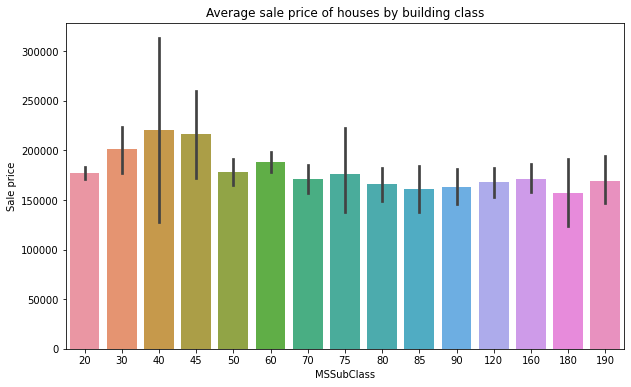

In [9]:
plt.figure(figsize=(10,6))

plt.title("Average sale price of houses by building class")

sns.barplot(x=X['MSSubClass'], y=y)

plt.ylabel("Sale price")